In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from imp import reload
from regain.covariance import kernel_time_graphical_lasso_; reload(kernel_time_graphical_lasso_)
from regain.datasets import kernels; reload(kernels)

n_dim = 4
n_times = 9
w_size = 3
n_samples = 30

data = kernels.make_ticc_dataset(w_size=w_size, n_dim=n_dim, n_samples=n_samples, T=n_times)
X, y = data.X, data.y

In [3]:
from sklearn.covariance import empirical_covariance
cov = []
for c in np.unique(y):
    idx = y == c
    cov.append(empirical_covariance(X[idx]))
cov = np.asarray(cov)

In [4]:
cov = thetas_true

NameError: name 'thetas_true' is not defined

In [5]:
kernel = np.zeros((cov.shape[0], cov.shape[0]))
for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[0]):
        kernel[i, j] = kernel[j, i] = (np.linalg.norm((cov[i]) - (cov[j])))

mm = np.sum(np.abs(kernel), axis=1)
kernel += np.eye(cov.shape[0]) * mm
# kernel /= mm

from regain.utils import normalize_matrix
normalize_matrix(kernel)

In [6]:
mdl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=1, kernel=kernel).fit(X, y)

In [7]:
from sklearn.gaussian_process import kernels
rbf = kernels.RBF

In [8]:
rbf

sklearn.gaussian_process.kernels.RBF

In [9]:
mdl = kernel_time_graphical_lasso_.KernelTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=1, kernel=rbf).fit(X, y)

from regain.norm import l1_od_norm
mdl.similarity_matrix = kernel_time_graphical_lasso_.precision_similarity(mdl.precision_, l1_od_norm)

In [10]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg

# needs distances
clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=2)
S = 1. / mdl.similarity_matrix - 1
labels_predict = clustering.fit_predict(S)

In [11]:
labels_pred = np.repeat(np.asarray(labels_predict), X.shape[0] / n_times)
labels_true = data.id_cluster

thetas_true = np.array([data.precs[i] for i in data.id_cluster_group])

In [12]:
print(data.id_cluster_group)
print(labels_predict)

from sklearn.metrics import v_measure_score
print(v_measure_score(data.id_cluster_group, labels_predict))

from regain.utils import structure_error, error_norm_time
print(structure_error(thetas_true, mdl.precision_, no_diagonal=True))
print(error_norm_time(thetas_true, mdl.precision_))

[0 0 0 1 1 1 0 0 0]
[0 0 0 0 0 0 0 1 1]
0.18069212842447646
{'tp': 106, 'tn': 0, 'fp': 0, 'fn': 2, 'precision': 1.0, 'recall': 0.9814814814814815, 'f1': 0.9906542056074767, 'accuracy': 0.7361111111111112, 'false_omission_rate': 1.0, 'fdr': 0.0, 'npv': 0.0, 'prevalence': 0.75, 'miss_rate': 0.018518518518518517, 'fall_out': 1, 'specificity': 0.0, 'plr': 0.9814814814814815, 'nlr': 0, 'dor': 0, 'balanced_accuracy': 0.49074074074074076, 'average_precision': 0.8246394073011829}
1.9875135377438324


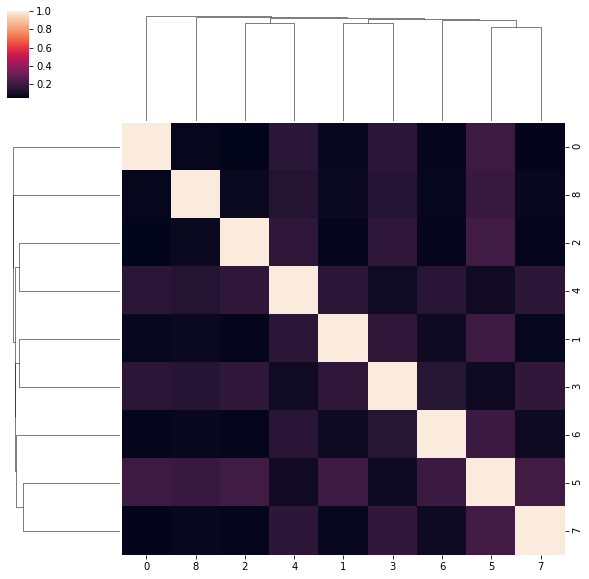

In [13]:
import seaborn as sns
sns.clustermap(kernel)

In [14]:
def make_datasets(n_obs=10, degree=2, clusters=3, T=15, n_samples=100, repetitions=False):
    clusters_reps = [nx.random_regular_graph(d=degree, n=n_obs) for i in range(clusters)]
    adjacencies = []
    for i in range(clusters):
        A = nx.adjacency_matrix(clusters_reps[i]).todense().astype(float)
        A[np.where(A!=0)]= np.random.rand(np.where(A!=0)[0].size)*0.45
        np.fill_diagonal(A, 1)
        adjacencies.append(A)
    
    pos = np.arange(0, T, T//(clusters+1))
    pos = np.sort(pos)
    pos = list(pos)+[T-1]
    
    thetas = []
    for i in range(len(pos)-1):
        how_many = int(pos[i+1]) - int(pos[i])-1
        new_list = [adjacencies[i%clusters]]
        target = adjacencies[(i+1)%clusters]

        for i in range(how_many):

            new = new_list[-1].copy()
            diffs = (new!=0).astype(int)-(target!=0).astype(int)
            diff = np.where(diffs!=0)
            if diff == ():
                break
            if(i==0):
                edges_per_change = int((np.nonzero(diffs)[0].shape[0]/2)//(how_many+1))
                if edges_per_change ==0:
                    edges_per_change+=1
            ixs = np.arange(diff[0].shape[0])
            np.random.shuffle(ixs)

            xs = diff[0][ixs[:edges_per_change]]
            ys = diff[1][ixs[:edges_per_change]]
            for j in range(xs.shape[0]):
                if diffs[xs[j], ys[j]] == -1:
                    new[xs[j], ys[j]] = np.random.rand(1)*0.2
                    new[ ys[j], xs[j]]=  new[xs[j], ys[j]]
                else:
                    new[xs[j], ys[j]] = 0
                    new[ ys[j], xs[j]]=0
            new_list.append(new)

        thetas += new_list
    thetas.append(target)
    covs = [np.linalg.inv(t) for t in thetas]
    samples = [np.random.multivariate_normal(np.zeros(n_obs), c, size=n_samples) for c in covs]
    return thetas, samples, covs, clusters_reps, pos

In [15]:
thetas, samples, covs, clusters_reps, pos= make_datasets(n_obs=10, degree=2, clusters=3, T=15, repetitions=False)

/Users/federicot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: covariance is not symmetric positive-semidefinite.


/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


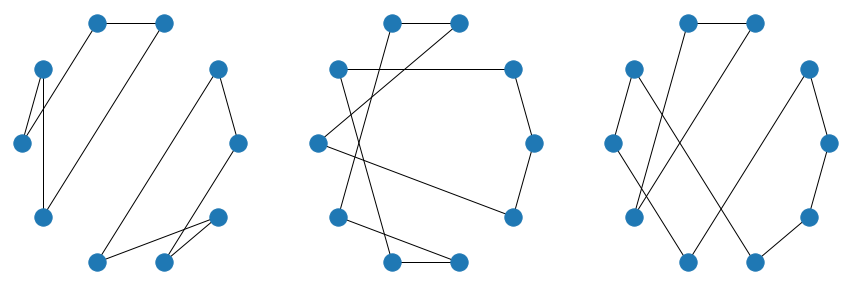

In [16]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
colors = ['red', 'blue', 'green']
for i in range(3):
    nx.draw_circular(clusters_reps[i], ax=axs[i])
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instea

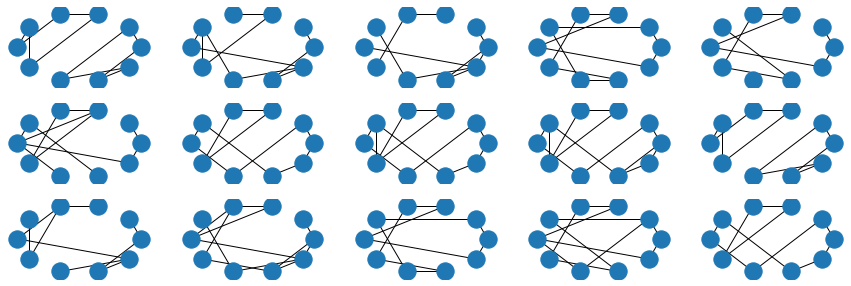

In [17]:
fig, axs = plt.subplots(3,5, figsize=(15,5))
colors = ['red', 'red', 'red', 'blue', 'blue', 'blue']
k = 0
for i in range(3):
    for j in range(5):
        g = nx.from_numpy_array(thetas[k])
        nx.draw_circular(g, ax=axs[i, j])
        k+=1
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

In [18]:
from regain.norm import l1_norm
distances = np.zeros((15,15))
for i, t in enumerate(thetas):
    for j, t1 in enumerate(thetas):
        distances[i,j] = l1_norm(t-t1)

distances /= np.max(distances)

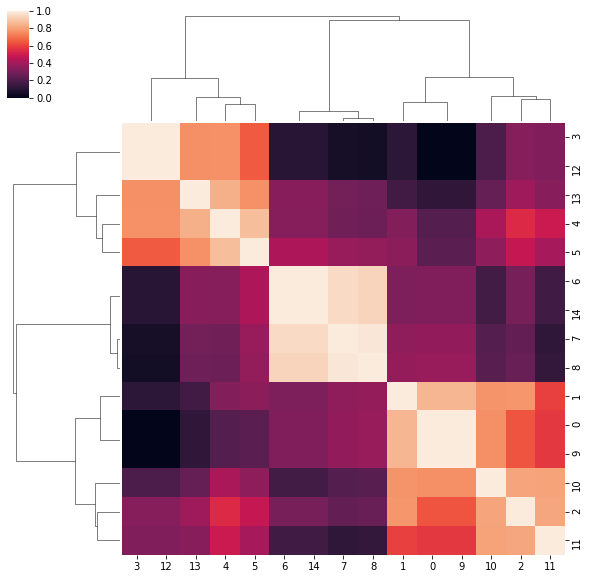

In [19]:
sns.clustermap(1-distances)

In [20]:
samples = np.array(samples)

X = np.vstack(samples)
y = np.repeat(np.arange(samples.shape[0]), samples.shape[1])

In [21]:
from importlib import reload
import regain.clustering; reload(regain.clustering)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_)
import regain.covariance.kernel_time_graphical_lasso_; reload(regain.covariance.kernel_time_graphical_lasso_)
from regain.covariance.kernel_time_graphical_lasso_ import SimilarityTimeGraphicalLasso

In [22]:
stgl = SimilarityTimeGraphicalLasso(alpha=1, beta=1, psi='l1', verbose=0, max_iter=500).fit(X, y)

In [30]:
stgl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=1,
                                                                 ).fit(X, y)

# from regain.norm import l1_od_norm
# stgl.similarity_matrix = kernel_time_graphical_lasso_.precision_similarity(stgl.precision_, l1_od_norm)


In [31]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg

# needs distances
clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=3)
S = 1. / stgl.similarity_matrix - 1
labels_predict = clustering.fit_predict(S)
labels_true = clustering.fit_predict(distances)

print(labels_predict)
print(labels_true)

[1 0 0 0 0 0 2 2 2 1 1 0 2 2 0]
[0 0 0 1 1 1 2 2 2 0 0 0 1 1 2]


In [32]:
from sklearn.metrics import v_measure_score
print(v_measure_score(labels_true, labels_predict))

from regain.utils import structure_error
structure_error(np.array(thetas), stgl.precision_)

0.36844989756795987


{'tp': 452,
 'tn': 30,
 'fp': 1016,
 'fn': 2,
 'precision': 0.3079019073569482,
 'recall': 0.9955947136563876,
 'f1': 0.47034339229968786,
 'accuracy': 0.32133333333333336,
 'false_omission_rate': 0.0625,
 'fdr': 0.6920980926430518,
 'npv': 0.9375,
 'prevalence': 0.30266666666666664,
 'miss_rate': 0.004405286343612335,
 'fall_out': 0.97131931166348,
 'specificity': 0.028680688336520075,
 'plr': 1.02499219535884,
 'nlr': 0.1535976505139501,
 'dor': 6.673228346456691,
 'balanced_accuracy': 0.5121377009964538,
 'average_precision': 0.7929946272531248}